In [1]:
import os
from pprint import pprint
import sys
import json

import ipywidgets as widgets
import mne
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.signal import freqz

sys.path.append('..')

from sleeprnn.common import constants, pkeys, viz
from sleeprnn.data import utils, stamp_correction
from sleeprnn.data.cap_full_ss import ALL_IDS
from sleeprnn.detection import metrics

viz.notebook_full_width()
%matplotlib inline

DATASET_DIR = os.path.abspath(os.path.join(utils.PATH_DATA, 'unlabeled_cap_npz'))

# Loader to read on-demand

In [2]:
def get_id(i):
    return ALL_IDS[i]


class CapFullLoader(object):
    def __init__(self, fs=200, min_ss_duration=0.3, max_ss_duration=3.0, page_duration=20, dataset_dir=DATASET_DIR):
        self.fs = fs
        self.min_ss_duration = min_ss_duration
        self.max_ss_duration = max_ss_duration
        self.page_duration = page_duration
        # Parameters of dataset
        self.original_page_duration = 30
        self.n2_id = 'S2'
        self.dataset_dir = dataset_dir
        
    def read_subject_data(self, subject_id):
        file_npz, file_spindle_1, file_spindle_2 = self.get_file_paths(subject_id)
        signal, hypnogram_original, meta = self.read_npz(file_npz)
        n2_pages = self.get_n2_pages(hypnogram_original)
        all_pages = self.get_all_pages(signal.size)
        marks_1 = self.read_marks(file_spindle_1)
        marks_2 = self.read_marks(file_spindle_2)
        # n2 filtering in 20s pages
        page_size = int(self.fs * self.page_duration)
        marks_1_n2 = utils.extract_pages_for_stamps(marks_1, n2_pages, page_size)
        marks_2_n2 = utils.extract_pages_for_stamps(marks_2, n2_pages, page_size)
        
        subject_data_dict = {
            'signal': signal,
            'hypnogram_original': hypnogram_original,
            'n2_pages': n2_pages,
            'wn_pages': all_pages,
            'spindle1_all': marks_1,
            'spindle2_all': marks_2,
            'spindle1_n2': marks_1_n2,
            'spindle2_n2': marks_2_n2,
            'metadata': meta
        }
        return subject_data_dict
    
    def get_file_paths(self, subject_id):
        file_npz = os.path.join(self.dataset_dir, 'register_and_state', "cap_%s.npz" % subject_id)
        file_spindle_1 = os.path.join(
            self.dataset_dir, 'spindle',
            'spindle_1',
            'EventDetection_s%s_absSigPow(1.75)_relSigPow(1.6)_sigCov(1.8)_sigCorr(0.75).txt' % subject_id)
        file_spindle_2 = os.path.join(
            self.dataset_dir, 'spindle',
            'spindle_2',
            'EventDetection_s%s_absSigPow(1.25)_relSigPow(1.6)_sigCov(1.3)_sigCorr(0.69).txt' % subject_id)
        return file_npz, file_spindle_1, file_spindle_2
    
    def read_npz(self, file_path):
        data = np.load(file_path)
        hypnogram = data['hypnogram']
        signal = data['signal']
        # Signal is already filtered to 0.1-35 and sampled to 200Hz
        original_fs = data['sampling_rate']
        # Now resample to the required frequency
        if self.fs != original_fs:
            print('Resampling from %d Hz to required %d Hz' % (original_fs, self.fs))
            signal = utils.resample_signal(signal, fs_old=original_fs, fs_new=self.fs)
        signal = signal.astype(np.float32)
        meta = {}
        for key in data.files:
            if key not in ['signal', 'hypnogram']:
                meta[key] = data[key].item()
        return signal, hypnogram, meta
    
    def get_n2_pages(self, hypnogram_original):
        signal_total_duration = len(hypnogram_original) * self.original_page_duration
        # Extract N2 pages
        n2_pages_original = np.where(hypnogram_original == self.n2_id)[0]
        onsets_original = n2_pages_original * self.original_page_duration
        offsets_original = (n2_pages_original + 1) * self.original_page_duration
        total_pages = int(np.ceil(signal_total_duration / self.page_duration))
        n2_pages_onehot = np.zeros(total_pages, dtype=np.int16)
        for i in range(total_pages):
            onset_new_page = i * self.page_duration
            offset_new_page = (i + 1) * self.page_duration
            for j in range(n2_pages_original.size):
                intersection = (onset_new_page < offsets_original[j]) and (onsets_original[j] < offset_new_page)
                if intersection:
                    n2_pages_onehot[i] = 1
                    break
        n2_pages = np.where(n2_pages_onehot == 1)[0]
        # Drop first, last and second to last page of the whole registers
        # if they where selected.
        last_page = total_pages - 1
        n2_pages = n2_pages[
            (n2_pages != 0)
            & (n2_pages != last_page)
            & (n2_pages != last_page - 1)]
        n2_pages = n2_pages.astype(np.int16)
        return n2_pages
    
    def get_all_pages(self, signal_length):
        total_pages = int(np.ceil(signal_length / (self.fs * self.page_duration)))
        all_pages = np.arange(1, total_pages - 2, dtype=np.int16)
        return all_pages
    
    def read_marks(self, file_path):
        pred_data = pd.read_csv(file_path, sep='\t')
        # We substract 1 to translate from matlab to numpy indexing system
        start_samples = pred_data.start_sample.values - 1
        end_samples = pred_data.end_sample.values - 1
        marks = np.stack([start_samples, end_samples], axis=1).astype(np.int32)
        # Sample-stamps assume 200Hz sampling rate
        if self.fs != 200:
            print('Correcting marks from 200 Hz to %d Hz' % self.fs)
            # We need to transform the marks to the new sampling rate
            marks_time = marks.astype(np.float32) / 200.0
            # Transform to sample-stamps
            marks = np.round(marks_time * self.fs).astype(np.int32)
        # Combine marks that are too close according to standards
        marks = stamp_correction.combine_close_stamps(marks, self.fs, self.min_ss_duration)
        # Fix durations that are outside standards
        marks = stamp_correction.filter_duration_stamps(marks, self.fs, self.min_ss_duration, self.max_ss_duration)
        return marks

In [3]:
loader = CapFullLoader()

# Check single subject

In [192]:
subject_id = '2-001' # get_id(6)
print("Subject id %s" % subject_id)
data = loader.read_subject_data(subject_id)
print("Available keys:", list(data.keys()))

print("")
for key in data.keys():
    if 'metadata' not in key:
        print(key, data[key].shape, data[key].dtype)
print("Metadata:")
pprint(data['metadata'])

print("")
spindle1_n2_original = utils.extract_pages_for_stamps(
    data['spindle1_all'], 
    np.where(data['hypnogram_original'] == loader.n2_id)[0], 
    int(loader.original_page_duration * loader.fs)
)
print("spindle 1 in N2 original:", spindle1_n2_original.shape)

spindle2_n2_original = utils.extract_pages_for_stamps(
    data['spindle2_all'], 
    np.where(data['hypnogram_original'] == loader.n2_id)[0], 
    int(loader.original_page_duration * loader.fs)
)
print("spindle 2 in N2 original:", spindle2_n2_original.shape)

Subject id 2-001
Available keys: ['signal', 'hypnogram_original', 'n2_pages', 'wn_pages', 'spindle1_all', 'spindle2_all', 'spindle1_n2', 'spindle2_n2', 'metadata']

signal (2868200,) float32
hypnogram_original (479,) <U3
n2_pages (225,) int16
wn_pages (715,) int16
spindle1_all (202, 2) int32
spindle2_all (502, 2) int32
spindle1_n2 (135, 2) int32
spindle2_n2 (295, 2) int32
Metadata:
{'bandpass_filter': 'scipy.signal.butter, 0.1-35Hz, order 3',
 'channel': 'C4-A1',
 'dataset_id': 'CAP Sleep Database',
 'original_sampling_rate': 512,
 'resampling_function': 'scipy.signal.resample_poly',
 'sampling_rate': 200,
 'scoring_epoch_duration_seconds': 30,
 'signal_physical_units': 'microvolts',
 'start_time_hh_mm_ss': '21:54:57',
 'subject_id': '2-001'}

spindle 1 in N2 original: (130, 2)
spindle 2 in N2 original: (282, 2)


### General Statistics

In [193]:
print("Subject %s" % subject_id)

print("Signal total duration: %1.2f [s] (%1.2f [h])" % (
    data['signal'].size / loader.fs,
    data['signal'].size / loader.fs / 3600,
))
print("Total REM sleep (original): %1.2f [h]" % (
    np.sum(
        data['hypnogram_original'] == 'R'
    ) * loader.original_page_duration / 3600
))
print("Total NREM sleep (original): %1.2f [h]" % (
    np.sum(
        (data['hypnogram_original'] == 'S1')
        | (data['hypnogram_original'] == 'S2')
        | (data['hypnogram_original'] == 'S3')
        | (data['hypnogram_original'] == 'S4')
    ) * loader.original_page_duration / 3600
))
print("Total N2 sleep (original): %1.2f [h]" % (
    np.sum(
        (data['hypnogram_original'] == 'S2')
    ) * loader.original_page_duration / 3600
))
print("Fraction N2 / Sleep (original): %1.2f %%" % (
    100 * np.sum(data['hypnogram_original'] == 'S2') / np.sum(
        (data['hypnogram_original'] == 'S1')
        | (data['hypnogram_original'] == 'S2')
        | (data['hypnogram_original'] == 'S3')
        | (data['hypnogram_original'] == 'S4')
        | (data['hypnogram_original'] == 'R')
    )
))
print("N spindle 1 in N2: %d" % data['spindle1_n2'].shape[0])
print("N spindle 2 in N2: %d" % data['spindle2_n2'].shape[0])
duration_1 = (data['spindle1_n2'][:, 1] - data['spindle1_n2'][:, 0] + 1) / loader.fs
duration_2 = (data['spindle2_n2'][:, 1] - data['spindle2_n2'][:, 0] + 1) / loader.fs
print("Min-Mean-Max duration spindle 1 in N2: %1.6fs - %1.6fs - %1.6fs" % (
    np.min(duration_1), np.mean(duration_1), np.max(duration_1)
))
print("Min-Mean-Max duration spindle 2 in N2: %1.6fs - %1.6fs - %1.6fs" % (
    np.min(duration_2), np.mean(duration_2), np.max(duration_2)
))
print("Density of spindle 1 (in N2 original): %1.4f spm" % (
    spindle1_n2_original.shape[0] / (
        np.sum((data['hypnogram_original'] == 'S2')) * loader.original_page_duration / 60
    )
))
print("Density of spindle 2 (in N2 original): %1.4f spm" % (
    spindle2_n2_original.shape[0] / (
        np.sum((data['hypnogram_original'] == 'S2')) * loader.original_page_duration / 60
    )
))

print("Range of signal min-mean-max and std: %1.4f, %1.4f, %1.4f, %1.4f" % (
    data['signal'].min(),
    data['signal'].mean(),
    data['signal'].max(),
    data['signal'].std(),
))

Subject 2-001
Signal total duration: 14341.00 [s] (3.98 [h])
Total REM sleep (original): 0.00 [h]
Total NREM sleep (original): 2.63 [h]
Total N2 sleep (original): 1.20 [h]
Fraction N2 / Sleep (original): 45.57 %
N spindle 1 in N2: 135
N spindle 2 in N2: 295
Min-Mean-Max duration spindle 1 in N2: 0.300000s - 0.711111s - 2.000000s
Min-Mean-Max duration spindle 2 in N2: 0.300000s - 0.974576s - 2.900000s
Density of spindle 1 (in N2 original): 1.8056 spm
Density of spindle 2 (in N2 original): 3.9167 spm
Range of signal min-mean-max and std: -1088.6173, -0.0001, 1149.3634, 40.2954


In [194]:
# std only in sleep
rem_pages = np.where(data['hypnogram_original'] == 'R')[0]
nrem_pages = np.where(
    (data['hypnogram_original'] == 'S1') | (data['hypnogram_original'] == 'S2') | (data['hypnogram_original'] == 'S3') | (data['hypnogram_original'] == 'S4')
)[0]
signal_rem = utils.extract_pages(data['signal'], rem_pages, int(loader.fs * loader.original_page_duration))
signal_nrem = utils.extract_pages(data['signal'], nrem_pages, int(loader.fs * loader.original_page_duration))
print('REM ranges min-max-mean-std:', signal_rem.min(), signal_rem.max(), signal_rem.mean(), signal_rem.std())
print('NREM ranges min-max-mean-std:', signal_nrem.min(), signal_nrem.max(), signal_nrem.mean(), signal_nrem.std())

ValueError: zero-size array to reduction operation maximum which has no identity

In [195]:
values, counts = np.unique(data['hypnogram_original'], return_counts=True)
for v, c in zip(values, counts):
    print("Label %s with count %d" % (v, c))

Label ? with count 46
Label MT with count 5
Label REM with count 67
Label S1 with count 34
Label S2 with count 144
Label S3 with count 39
Label S4 with count 99
Label W with count 45


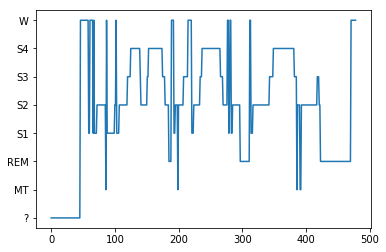

In [196]:
plt.plot(data['hypnogram_original'])

### N2 spectrum

In [ ]:
# spectrum
segmented_signal = utils.extract_pages(data['signal'], data['n2_pages'], int(loader.fs * loader.page_duration))
print("Segmented signal", segmented_signal.shape)
all_pages_power = []
for page_signal in segmented_signal:
    power, freq = utils.power_spectrum(page_signal, loader.fs, apply_hanning=True)
    all_pages_power.append(power)

pages_power = np.stack(all_pages_power, axis=0)
min_freq = 0.5
max_freq = 30
plot_indices = np.where((freq >= min_freq) & (freq <= max_freq))[0]
plot_pages_power = pages_power[:, plot_indices]
plot_freq = freq[plot_indices]
plot_power_min = np.min(plot_pages_power, axis=0)
plot_power_max = np.min(plot_pages_power, axis=0)
plot_power_mean = np.mean(plot_pages_power, axis=0)
plot_power_25, plot_power_50, plot_power_75 = np.percentile(plot_pages_power, (25, 50, 75), axis=0)

fig, axes = plt.subplots(1, 2, figsize=(8, 4), dpi=120)

ax = axes[0]
ax.plot(plot_freq, plot_power_50, color=viz.PALETTE['blue'], linewidth=1, label='median')
ax.fill_between(plot_freq, plot_power_25, plot_power_75, facecolor=viz.PALETTE['blue'], alpha=0.3, label='iqr')
ax.set_xlabel("Frequency (Hz)")
ax.set_yticks([])
ax.legend(loc='upper right')
ax.set_title('Subject %s, N2, channel %s' % (subject_id, data['metadata']['channel']))

ax = axes[1]
ax.plot(plot_freq, np.log10(plot_power_50), color=viz.PALETTE['blue'], linewidth=1, label='median')
ax.fill_between(plot_freq, np.log10(plot_power_25), np.log10(plot_power_75), facecolor=viz.PALETTE['blue'], alpha=0.3, label='iqr')
ax.set_xlabel("Frequency (Hz)")
ax.set_yticks([])
ax.legend(loc='upper right')
ax.set_title('log')

plt.tight_layout()
plt.show()

### Segment visualization

In [ ]:
center_loc = np.random.RandomState(seed=0).choice(data['spindle1_n2'].mean(axis=1).astype(np.int32))
window_size = 15
start_sample = int(center_loc - window_size * loader.fs // 2)
end_sample = int(start_sample + window_size * loader.fs)

time_axis = np.arange(start_sample, end_sample) / loader.fs
fig, ax = plt.subplots(1, 1, figsize=(14, 3), dpi=120)
ax.plot(time_axis, data['signal'][start_sample:end_sample], linewidth=0.7)
ax.set_xlim([start_sample/loader.fs, end_sample/loader.fs])
ax.set_ylim([-100, 100])

spindle1 = utils.filter_stamps(data['spindle1_n2'], start_sample, end_sample)
spindle2 = utils.filter_stamps(data['spindle2_n2'], start_sample, end_sample)
for i, mark in enumerate(spindle1):
    label = 'Spindle 1' if i == 0 else None
    ax.plot(mark / loader.fs, [-50, -50], color=viz.PALETTE['red'], linewidth=4, alpha=0.4, label=label)
for i, mark in enumerate(spindle2):
    label = 'Spindle 2' if i == 0 else None
    ax.plot(mark / loader.fs, [-60, -60], color=viz.PALETTE['blue'], linewidth=4, alpha=0.4, label=label)
ax.set_title("Subject %s, channel %s" % (subject_id, data['metadata']['channel']))
ax.legend(loc='upper right')
plt.show()

### Agreement between spindle1 and spindle2

In [ ]:
iou_matching, idx_matching = metrics.matching(spindle1_n2_original, spindle2_n2_original)
iou_thr_list = np.linspace(0, 1, 21)[1:-2]
recall_vs_iou = metrics.metric_vs_iou(spindle1_n2_original, spindle2_n2_original, iou_thr_list, metric_name=constants.RECALL, iou_matching=iou_matching)
precision_vs_iou = metrics.metric_vs_iou(spindle1_n2_original, spindle2_n2_original, iou_thr_list, metric_name=constants.PRECISION, iou_matching=iou_matching)
f1score_vs_iou = metrics.metric_vs_iou(spindle1_n2_original, spindle2_n2_original, iou_thr_list, metric_name=constants.F1_SCORE, iou_matching=iou_matching)

fig, axes = plt.subplots(1, 3, figsize=(12, 4), dpi=120)

ax = axes[0]
ax.plot(iou_thr_list, f1score_vs_iou, linewidth=1, color=viz.PALETTE['blue'], marker='o', markersize=3)
ax.set_xlim([0, 1])
ax.set_xlabel("IoU threshold")
ax.set_ylabel("F1-score")
ax.set_ylim([0, 1])
ax.grid()
ax.set_title("Subject %s, spindles agreement" % subject_id)

ax = axes[1]
ax.plot(recall_vs_iou, precision_vs_iou, linewidth=1, color=viz.PALETTE['blue'], marker='o', markersize=3)
iou_02_loc = np.argmin((iou_thr_list - 0.2)**2)
ax.plot(recall_vs_iou[iou_02_loc], precision_vs_iou[iou_02_loc], color=viz.PALETTE['red'], marker='o', markersize=5, label="IoU > 0.2")
ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.grid()
ax.set_title("Spindles-2 as detections")
ax.legend(loc="upper left")

ax = axes[2]
iou_of_matchings = iou_matching[idx_matching != -1]
bins = np.linspace(0, 1, 11)
ax.hist(iou_of_matchings, bins=bins, color=viz.PALETTE['blue'])
mean_iou_of_matchings = np.mean(iou_of_matchings)
ax.axvline(mean_iou_of_matchings, color='k', linestyle='--', linewidth=2)
ax.set_xlim([0, 1])
ax.set_ylim([0, None])
ax.set_title("mIoU %1.2f %%" % (100 * mean_iou_of_matchings))
ax.set_xlabel("IoU of matchings")
ax.set_yticks([])

plt.tight_layout()
plt.show()

# CAP subject's N2 mean spectrum

In [ ]:
spectrum_dict = {}
min_freq = 0.5
max_freq = 30
for subject_id in ALL_IDS:
    data = loader.read_subject_data(subject_id)
    # spectrum
    segmented_signal = utils.extract_pages(data['signal'], data['n2_pages'], int(loader.fs * loader.page_duration))
    all_pages_power = []
    for page_signal in segmented_signal:
        power, freq = utils.power_spectrum(page_signal, loader.fs, apply_hanning=True)
        all_pages_power.append(power)
    pages_power = np.stack(all_pages_power, axis=0)
    plot_indices = np.where((freq >= min_freq) & (freq <= max_freq))[0]
    plot_pages_power = pages_power[:, plot_indices]
    plot_freq = freq[plot_indices]
    plot_power_mean = np.mean(plot_pages_power, axis=0)
    spectrum_dict[subject_id] = np.stack([plot_freq, plot_power_mean], axis=1)

In [ ]:
def show_all_fft(emph_subject=None, sample_from='spindle1_n2', save_plots=False, collapse_background=True):    
    if save_plots:
        savedir = os.path.join('spectrum_validation', 'subject_%s' % emph_subject)
        os.makedirs(savedir, exist_ok=True)
    emph_subject = [] if emph_subject is None else [emph_subject]
    
    # Show FFT
    fig, axes = plt.subplots(1, 2, figsize=(8, 4), dpi=120)
    ax = axes[0]
    ax.set_title('CAP subjects (n=%d), N2 average' % len(ALL_IDS))
    for subject_id in ALL_IDS:
        if subject_id in emph_subject:
            ax.plot(spectrum_dict[subject_id][:, 0], spectrum_dict[subject_id][:, 1], linewidth=1.0, color=viz.PALETTE['blue'], alpha=1, zorder=20, label=subject_id)
        elif not collapse_background:
            ax.plot(spectrum_dict[subject_id][:, 0], spectrum_dict[subject_id][:, 1], linewidth=0.7, color=viz.GREY_COLORS[5], alpha=0.3)
    if collapse_background:
        all_subjects_spectrum = np.stack([spectrum_dict[subject_id][:, 1] for subject_id in ALL_IDS], axis=0)
        plot_lowest, plot_low, plot_median, plot_high, plot_highest = np.percentile(all_subjects_spectrum, (5, 25, 50, 75, 95), axis=0)
        ax.plot(spectrum_dict[ALL_IDS[0]][:, 0], plot_median, linewidth=1, color=viz.GREY_COLORS[5], alpha=1)
        ax.fill_between(
            spectrum_dict[ALL_IDS[0]][:, 0], plot_low, plot_high,
            facecolor=viz.GREY_COLORS[5], alpha=0.3)
        ax.fill_between(
            spectrum_dict[ALL_IDS[0]][:, 0], plot_lowest, plot_highest,
            facecolor=viz.GREY_COLORS[5], alpha=0.3)
    ax.set_xlabel("Frequency (Hz)")
    ax.set_yticks([])
    ax.legend(loc='upper right')
    ax = axes[1]
    for subject_id in ALL_IDS:
        if subject_id in emph_subject:
            ax.plot(spectrum_dict[subject_id][:, 0], np.log10(spectrum_dict[subject_id][:, 1]), linewidth=1.0, color=viz.PALETTE['blue'], alpha=1, zorder=20, label=subject_id)
        elif not collapse_background:
            ax.plot(spectrum_dict[subject_id][:, 0], np.log10(spectrum_dict[subject_id][:, 1]), linewidth=0.7, color=viz.GREY_COLORS[5], alpha=0.3)
    if collapse_background:
        ax.plot(spectrum_dict[ALL_IDS[0]][:, 0], np.log10(plot_median), linewidth=1, color=viz.GREY_COLORS[5], alpha=1)
        ax.fill_between(
            spectrum_dict[ALL_IDS[0]][:, 0], np.log10(plot_low), np.log10(plot_high),
            facecolor=viz.GREY_COLORS[5], alpha=0.3)
        ax.fill_between(
            spectrum_dict[ALL_IDS[0]][:, 0], np.log10(plot_lowest), np.log10(plot_highest),
            facecolor=viz.GREY_COLORS[5], alpha=0.3)
    ax.set_xlabel("Frequency (Hz)")
    ax.set_yticks([])
    ax.legend(loc='upper right')
    ax.set_title('log')
    plt.tight_layout()
    if save_plots:
        plt.savefig(os.path.join(savedir, "spectrum_collapse%s.png" % collapse_background), dpi=200)
    plt.show()
    
    # Show some pages
    if emph_subject:
        data = loader.read_subject_data(emph_subject[0])
        center_locs = np.random.RandomState(seed=0).choice(data[sample_from].mean(axis=1).astype(np.int32), size=4, replace=False)
        center_locs = np.sort(center_locs)
        for segment_id, center_loc in enumerate(center_locs):
            window_size = 15
            start_sample = int(center_loc - window_size * loader.fs // 2)
            end_sample = int(start_sample + window_size * loader.fs)

            time_axis = np.arange(start_sample, end_sample) / loader.fs
            fig, ax = plt.subplots(1, 1, figsize=(14, 3), dpi=80)
            ax.plot(time_axis, data['signal'][start_sample:end_sample], linewidth=0.7)
            ax.set_xlim([start_sample/loader.fs, end_sample/loader.fs])
            ax.set_ylim([-100, 100])

            spindle1 = utils.filter_stamps(data['spindle1_n2'], start_sample, end_sample)
            spindle2 = utils.filter_stamps(data['spindle2_n2'], start_sample, end_sample)
            for i, mark in enumerate(spindle1):
                label = 'Spindle 1' if i == 0 else None
                ax.plot(mark / loader.fs, [-50, -50], color=viz.PALETTE['red'], linewidth=4, alpha=0.4, label=label)
            for i, mark in enumerate(spindle2):
                label = 'Spindle 2' if i == 0 else None
                ax.plot(mark / loader.fs, [-60, -60], color=viz.PALETTE['blue'], linewidth=4, alpha=0.4, label=label)
            ax.set_title("Subject %s, channel %s" % (emph_subject[0], data['metadata']['channel']))
            ax.legend(loc='upper right')
            plt.tight_layout()
            if save_plots:
                plt.savefig(os.path.join(savedir, "segment_%d.png" % segment_id), dpi=200)
            plt.show()

In [ ]:
show_all_fft(
    '7-011',# get_id(104), 
    sample_from='spindle1_n2', save_plots=True)

# Check whole dataset statistics (N2 only)

In [ ]:
fname = os.path.join(DATASET_DIR, 'CAP_groups_ids.json')
with open(fname, 'r') as handle:
    PATHOLOGY_TO_GROUP_DICT = json.load(handle)
GROUP_TO_PATHOLOGY_DICT = {v: k for k, v in PATHOLOGY_TO_GROUP_DICT.items()}
fname = os.path.join(DATASET_DIR, 'gender-age.xlsx')
GENDER_AGE_TABLE = pd.read_excel(fname, header=None, names=['subject_id', 'gender', 'age'])
GENDER_AGE_TABLE['subject_id'] = GENDER_AGE_TABLE['subject_id'].apply(lambda x: x.strip())
GENDER_AGE_TABLE['subject_id'] = GENDER_AGE_TABLE['subject_id'].apply(lambda x: x.replace('RDB', 'RBD'))
GENDER_AGE_TABLE['subject_id'] = GENDER_AGE_TABLE['subject_id'].apply(lambda x: x.replace('SBD', 'SDB'))

In [ ]:
def get_pathology(subject_id):
    group_id = int(subject_id.split("-")[0])
    pathology_abv = GROUP_TO_PATHOLOGY_DICT[group_id]
    return pathology_abv


def get_old_id(subject_id):
    first_part = get_pathology(subject_id)
    second_part = str(int(subject_id.split("-")[1]))
    return "".join([first_part, second_part])


def get_age_and_sex(subject_id):
    old_id = get_old_id(subject_id).upper()
    subject_row = GENDER_AGE_TABLE.loc[GENDER_AGE_TABLE['subject_id'] == old_id]
    age = subject_row['age'].values.item()
    sex = subject_row['gender'].values.item().lower()
    return age, sex


def get_mean_spectrum(stack_of_pages, fs):
    all_pages_power = []
    for page_signal in stack_of_pages:
        power, freq = utils.power_spectrum(page_signal, fs, apply_hanning=True)
        all_pages_power.append(power)
    power_mean = np.stack(all_pages_power, axis=0).mean(axis=0)
    return freq, power_mean


def listify_dictionaries(list_of_dicts, to_numpy=True):
    dict_of_lists = {}
    for key in list_of_dicts[0].keys():
        dict_of_lists[key] = []
        for single_dict in list_of_dicts:
            dict_of_lists[key].append(single_dict[key])
        if to_numpy:
            dict_of_lists[key] = np.asarray(dict_of_lists[key])
    return dict_of_lists


def analyze_spindle(spindle, fs):
    # Power ratio
    window_han = np.hanning(spindle.size)
    padding = np.zeros(1 * fs)
    padded_spindle = np.concatenate([padding, spindle * window_han, padding])
    amp, freqs = utils.power_spectrum(padded_spindle, fs, apply_hanning=False)
    num_power = amp[(freqs >= 11) & (freqs <= 16)].mean()
    den_power = amp[(freqs >= 4.5) & (freqs <= 30)].mean()
    power_ratio = num_power / (den_power + 1e-6)
    # other params
    duration = spindle.size / fs
    pp_amplitude = spindle.max() - spindle.min()
    rms = np.sqrt(np.mean(spindle ** 2))
    # Compute peak frequency by fft
    w, h = freqz(spindle)
    resp_freq = w * fs / (2*np.pi)
    resp_amp = abs(h)
    max_loc = np.argmax(resp_amp)
    central_freq_fft = resp_freq[max_loc]
    results = {
        'duration': duration,
        'amplitude_pp': pp_amplitude,
        'amplitude_rms': rms,
        'central_freq_fft': central_freq_fft,
        'power_ratio': power_ratio
    }
    return results

In [ ]:
page_size = int(loader.fs * loader.page_duration)
table_list = []
print("Generating table ", end='')
for subject_id in ALL_IDS:
    print('.', end='', flush=True)
    data = loader.read_subject_data(subject_id)
    
    age, sex = get_age_and_sex(subject_id)
    
    # Signal descriptors:
    signal_duration_hours = data['signal'].size / loader.fs / 3600
    signal_min = data['signal'].min()
    signal_mean = data['signal'].mean()
    signal_std = data['signal'].std()
    signal_max = data['signal'].max()
    
    # fft -> use original 20s n2 pages here
    stack_of_pages = utils.extract_pages(data['signal'], data['n2_pages'], page_size)
    freq, mean_power = get_mean_spectrum(stack_of_pages, loader.fs)
    mean_power_n2_mean_delta_slow = mean_power[(freq >= 0.5) & (freq <= 2)].mean()
    mean_power_n2_mean_delta_fast = mean_power[(freq >= 2) & (freq <= 4)].mean()
    mean_power_n2_mean_theta = mean_power[(freq >= 4) & (freq <= 8)].mean()
    mean_power_n2_mean_alpha = mean_power[(freq >= 8) & (freq <= 12)].mean()
    mean_power_n2_mean_sigma = mean_power[(freq >= 11) & (freq <= 16)].mean()
    mean_power_n2_mean_beta = mean_power[(freq >= 13) & (freq <= 30)].mean()
    # lacourse (a7) power ratio
    num_power = mean_power[(freq >= 11) & (freq <= 16)].mean()
    den_power = mean_power[(freq >= 4.5) & (freq <= 30)].mean()
    spectrum_power_ratio = num_power / (den_power + 1e-6)
    
    # original hypnogram descriptors:
    rem_duration_hours = np.sum(data['hypnogram_original'] == 'R') * loader.original_page_duration / 3600
    n1_duration_hours = np.sum(data['hypnogram_original'] == 'S1') * loader.original_page_duration / 3600
    n2_duration_hours = np.sum(data['hypnogram_original'] == 'S2') * loader.original_page_duration / 3600
    n3_duration_hours = np.sum(data['hypnogram_original'] == 'S3') * loader.original_page_duration / 3600
    n4_duration_hours = np.sum(data['hypnogram_original'] == 'S4') * loader.original_page_duration / 3600
    nrem_duration_hours = n1_duration_hours + n2_duration_hours + n3_duration_hours + n4_duration_hours
    sleep_duration_hours = rem_duration_hours + nrem_duration_hours
    n2_to_sleep_ratio = n2_duration_hours / sleep_duration_hours
    
    labels_in_hypno = np.unique(data['hypnogram_original'])
    valid_labels_list = ['?', 'R', 'S1', 'S2', 'S3', 'S4', 'W']
    flag_valid_hypno_labels = np.all([l in valid_labels_list for l in labels_in_hypno])
    
    # Spindles descriptors: -> use original n2 pages here
    spindles_1 = utils.extract_pages_for_stamps(
        data['spindle1_all'], 
        np.where(data['hypnogram_original'] == loader.n2_id)[0], 
        int(loader.original_page_duration * loader.fs))
    spindles_2 = utils.extract_pages_for_stamps(
        data['spindle2_all'], 
        np.where(data['hypnogram_original'] == loader.n2_id)[0], 
        int(loader.original_page_duration * loader.fs))
    
    spindles1_n2_number = spindles_1.shape[0]
    spindles1_n2_density = spindles1_n2_number / (n2_duration_hours * 60)
    spindles1_n2_mean_duration = np.mean(spindles_1[:, 1] - spindles_1[:, 0] + 1) / loader.fs
    
    spindles2_n2_number = spindles_2.shape[0]
    spindles2_n2_density = spindles2_n2_number / (n2_duration_hours * 60)
    spindles2_n2_mean_duration = np.mean(spindles_2[:, 1] - spindles_2[:, 0] + 1) / loader.fs
               
    iou_matching, idx_matching = metrics.matching(spindles_1, spindles_2)
    spindle_1_to_2_recall = metrics.metric_vs_iou(spindles_1, spindles_2, [0.2], metric_name=constants.RECALL, iou_matching=iou_matching)[0]
    spindle_1_to_2_precision = metrics.metric_vs_iou(spindles_1, spindles_2, [0.2], metric_name=constants.PRECISION, iou_matching=iou_matching)[0]
    spindle_1_to_2_f1score = metrics.metric_vs_iou(spindles_1, spindles_2, [0.2], metric_name=constants.F1_SCORE, iou_matching=iou_matching)[0]
    spindle_1_to_2_miou = np.mean(iou_matching[idx_matching != -1])
    
    # Spindle + signal descriptors: -> use original n2 pages here
    sigma_signal = utils.broad_filter(data['signal'], loader.fs, lowcut=10, highcut=17)
    # Spindle 1 parameters
    spindles = [sigma_signal[s_start:s_end] for (s_start, s_end) in spindles_1]
    analysis = [analyze_spindle(spindle, loader.fs) for spindle in spindles]
    if len(analysis) > 0:
        analysis = listify_dictionaries(analysis)
        spindles1_n2_freq = np.mean(analysis['central_freq_fft'])
        spindles1_n2_amplitude_pp = np.mean(analysis['amplitude_pp'])
        spindles1_n2_amplitude_rms = np.mean(analysis['amplitude_rms'])
        spindles1_n2_power_ratio = np.mean(analysis['power_ratio'])
    else:
        spindles1_n2_freq = np.nan
        spindles1_n2_amplitude_pp = np.nan
        spindles1_n2_amplitude_rms = np.nan
        spindles1_n2_power_ratio = np.nan
    # Spindle 2 parameters
    spindles = [sigma_signal[s_start:s_end] for (s_start, s_end) in spindles_2]
    analysis = [analyze_spindle(spindle, loader.fs) for spindle in spindles] 
    if len(analysis) > 0:
        analysis = listify_dictionaries(analysis)
        spindles2_n2_freq = np.mean(analysis['central_freq_fft'])
        spindles2_n2_amplitude_pp = np.mean(analysis['amplitude_pp'])
        spindles2_n2_amplitude_rms = np.mean(analysis['amplitude_rms'])
        spindles2_n2_power_ratio = np.mean(analysis['power_ratio'])
    else:
        spindles2_n2_freq = np.nan
        spindles2_n2_amplitude_pp = np.nan
        spindles2_n2_amplitude_rms = np.nan
        spindles2_n2_power_ratio = np.nan
    
    # Collect results
    tmp_dict = {
        'subject_id': subject_id,
        'channel': data['metadata']['channel'],
        'pathology': get_pathology(subject_id),
        'age': age,
        'sex': sex,
        'signal_hours': signal_duration_hours,
        'signal_min': signal_min,
        'signal_mean': signal_mean,
        'signal_std': signal_std,
        'signal_max': signal_max,
        'power_delta_slow': mean_power_n2_mean_delta_slow,
        'power_delta_fast': mean_power_n2_mean_delta_fast,
        'power_theta': mean_power_n2_mean_theta,
        'power_alpha': mean_power_n2_mean_alpha,
        'power_sigma': mean_power_n2_mean_sigma,
        'power_beta': mean_power_n2_mean_beta,
        'power_ratio': spectrum_power_ratio,
        'hypno_rem_hours': rem_duration_hours,
        'hypno_n1_hours': n1_duration_hours,
        'hypno_n2_hours': n2_duration_hours,
        'hypno_n3_hours': n3_duration_hours,
        'hypno_n4_hours': n4_duration_hours,
        'hypno_nrem_hours': nrem_duration_hours,
        'hypno_sleep_hours': sleep_duration_hours,
        'hypno_n2_to_sleep': n2_to_sleep_ratio,
        'hypno_flag_sanity': flag_valid_hypno_labels,
        's1_number': spindles1_n2_number,
        's1_density': spindles1_n2_density,
        's1_duration': spindles1_n2_mean_duration,
        's2_number': spindles2_n2_number,
        's2_density': spindles2_n2_density,
        's2_duration': spindles2_n2_mean_duration,
        'match12_recall': spindle_1_to_2_recall,
        'match12_precision': spindle_1_to_2_precision,
        'match12_f1score': spindle_1_to_2_f1score,
        'match12_miou': spindle_1_to_2_miou, 
        's1_freq': spindles1_n2_freq,
        's1_amp_pp': spindles1_n2_amplitude_pp,
        's1_amp_rms': spindles1_n2_amplitude_rms,
        's1_power_ratio': spindles1_n2_power_ratio,
        's2_freq': spindles2_n2_freq,
        's2_amp_pp': spindles2_n2_amplitude_pp,
        's2_amp_rms': spindles2_n2_amplitude_rms,
        's2_power_ratio': spindles2_n2_power_ratio
    }
    table_list.append(tmp_dict)
print(" Done")
big_table = pd.DataFrame(table_list)
big_table.to_csv(os.path.join(DATASET_DIR, 'big_table.csv'), index = False)
big_table.head()

In [4]:
# Load table from memory if already exists
big_table = pd.read_csv(os.path.join(DATASET_DIR, 'big_table.csv'))
print("Table with shape", big_table.shape)
big_table.head()

Table with shape (104, 44)


,subject_id,channel,pathology,age,sex,signal_hours,signal_min,signal_mean,signal_std,signal_max,...,match12_f1score,match12_miou,s1_freq,s1_amp_pp,s1_amp_rms,s1_power_ratio,s2_freq,s2_amp_pp,s2_amp_rms,s2_power_ratio
0,1-001,C4-A1,n,37,f,9.616667,-693.722351,0.000761,19.938787,449.330200,...,0.651224,0.584456,13.607422,40.123288,10.956236,4.042940,13.638067,33.662973,8.008141,4.180594
1,1-002,C4-A1,n,34,m,12.250000,-361.908936,0.001033,18.905073,411.918854,...,0.753452,0.739252,13.354577,47.737720,12.227225,3.866156,13.289328,43.194544,10.440300,3.854735
2,1-003,C4-A1,n,35,f,9.183611,-802.269592,-0.000113,23.741087,643.161072,...,0.441905,0.534438,13.393315,41.703911,11.184649,3.668290,13.157181,33.592781,7.940702,3.724424
3,1-004,C4-A1,n,25,f,9.927778,-629.273132,0.000532,20.362926,435.637604,...,0.789157,0.699981,13.227227,43.666849,11.506620,4.102276,13.214290,39.587462,9.673125,4.136671
4,1-005,C4-A1,n,35,f,8.733611,-947.683472,0.000358,22.980350,543.786194,...,0.764783,0.680081,13.328699,46.857011,12.177717,4.137713,13.311427,40.210202,9.496020,4.175193


# Check stats from big table

In [98]:
exclusion_list = pd.read_csv(os.path.join(DATASET_DIR, "exclusion_criteria.csv"), sep='\t')
exclusion_list = exclusion_list['id'].values
valid_ids = [s for s in ALL_IDS if s not in exclusion_list]
print("Valid ids: %d" % len(valid_ids))

big_table = big_table[big_table.subject_id.isin(valid_ids)]
print("Table with shape", big_table.shape)

Valid ids: 80
Table with shape (80, 44)


In [99]:
big_table['channel'].value_counts()#.plot(kind='bar')

C4-A1          72
C3-A2           4
C4A1            3
C4 minus A1     1
Name: channel, dtype: int64

In [100]:
big_table.loc[big_table['channel']=='C4 minus A1']

,subject_id,channel,pathology,age,sex,signal_hours,signal_min,signal_mean,signal_std,signal_max,...,match12_f1score,match12_miou,s1_freq,s1_amp_pp,s1_amp_rms,s1_power_ratio,s2_freq,s2_amp_pp,s2_amp_rms,s2_power_ratio
55,5-025,C4 minus A1,nfle,40,m,8.7,-373.115265,-0.000419,22.862835,372.420532,...,0.603816,0.708607,13.709491,47.507682,11.996333,3.654817,13.458635,41.970331,10.11337,3.569325


In [101]:
big_table['pathology'].value_counts()

nfle     35
n        16
plm       7
ins       7
rbd       7
narco     4
sdb       2
brux      2
Name: pathology, dtype: int64

In [102]:
big_table['sex'].value_counts()

m    45
f    35
Name: sex, dtype: int64

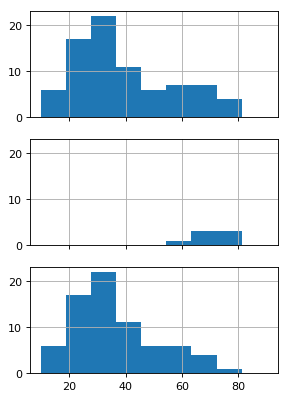

In [103]:
fig, ax = plt.subplots(3, 1, figsize=(4, 6), dpi=80, sharex=True, sharey=True)
big_table['age'].hist(ax=ax[0], bins=np.linspace(10, 90, 10))
big_table['age'].loc[big_table['pathology'] == 'rbd'].hist(ax=ax[1], bins=np.linspace(10, 90, 10))
big_table['age'].loc[big_table['pathology'] != 'rbd'].hist(ax=ax[2], bins=np.linspace(10, 90, 10))

In [104]:
big_table['pathology'].loc[big_table['age'] >= 50].value_counts()

rbd     7
ins     6
plm     6
nfle    2
sdb     2
Name: pathology, dtype: int64

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f6e4905f7b8>,
      dtype=object)

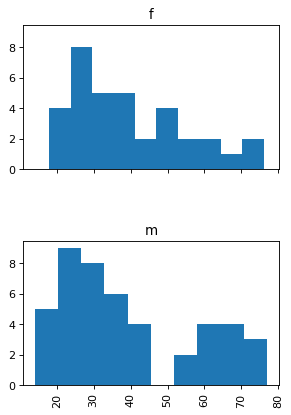

In [105]:
fig, ax = plt.subplots(2, 1, figsize=(4, 6), dpi=80, sharex=True, sharey=True)
big_table['age'].hist(by=big_table['sex'], ax=ax)

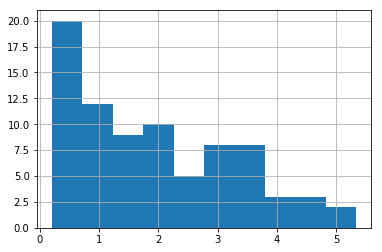

In [107]:
big_table['s1_density'].hist()

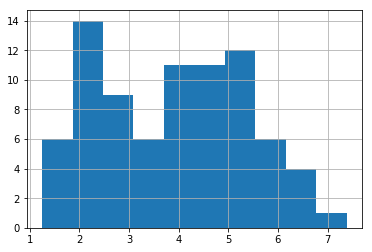

In [108]:
big_table['s2_density'].hist()

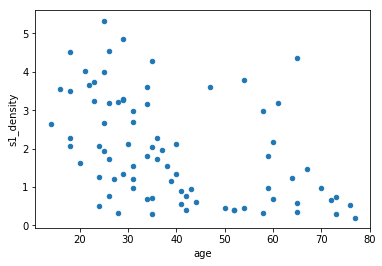

In [111]:
big_table.plot.scatter('age', 's1_density')

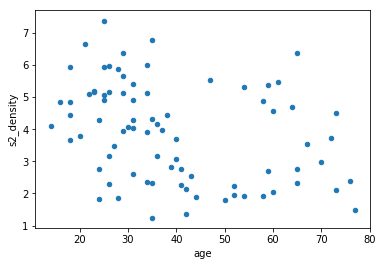

In [112]:
big_table.plot.scatter('age', 's2_density')

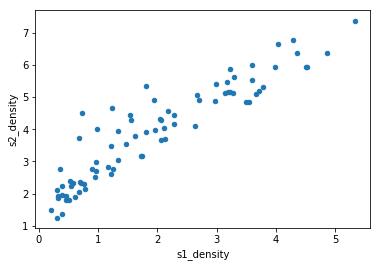

In [114]:
big_table.plot.scatter('s1_density', 's2_density')

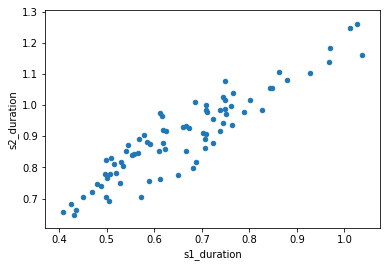

In [137]:
big_table.plot.scatter('s1_duration', 's2_duration')

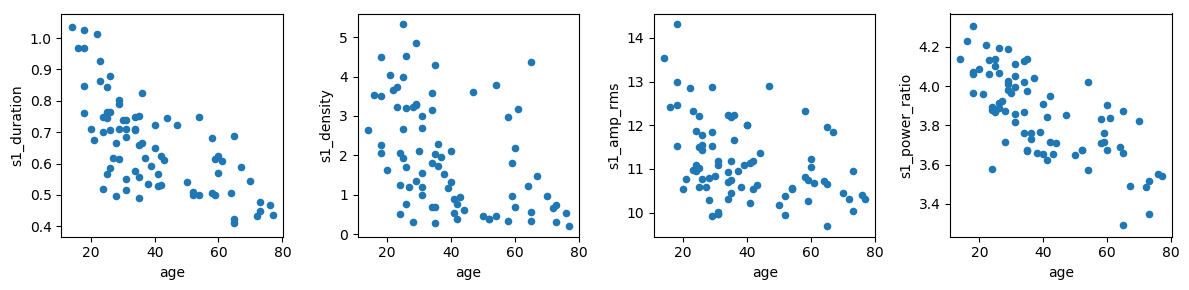

In [142]:
fig, ax = plt.subplots(1, 4, figsize=(12, 3), dpi=100)
big_table.plot.scatter('age', 's1_duration', ax=ax[0])
big_table.plot.scatter('age', 's1_density', ax=ax[1])
big_table.plot.scatter('age', 's1_amp_rms', ax=ax[2])
big_table.plot.scatter('age', 's1_power_ratio', ax=ax[3])
plt.tight_layout()
plt.show()

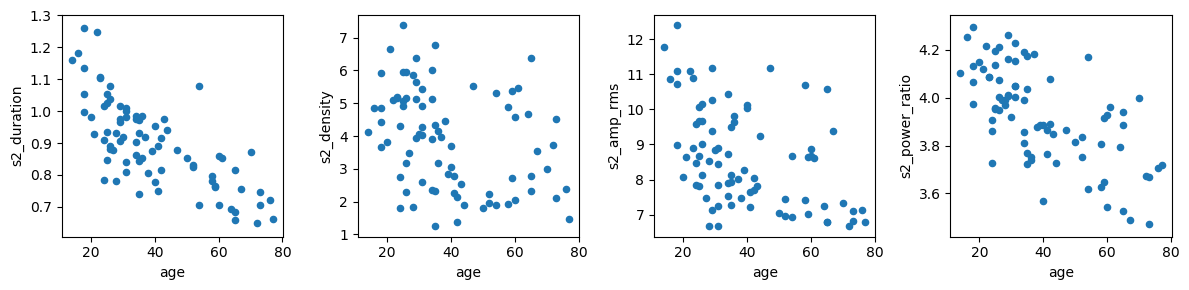

In [143]:
fig, ax = plt.subplots(1, 4, figsize=(12, 3), dpi=100)
big_table.plot.scatter('age', 's2_duration', ax=ax[0])
big_table.plot.scatter('age', 's2_density', ax=ax[1])
big_table.plot.scatter('age', 's2_amp_rms', ax=ax[2])
big_table.plot.scatter('age', 's2_power_ratio', ax=ax[3])
plt.tight_layout()
plt.show()

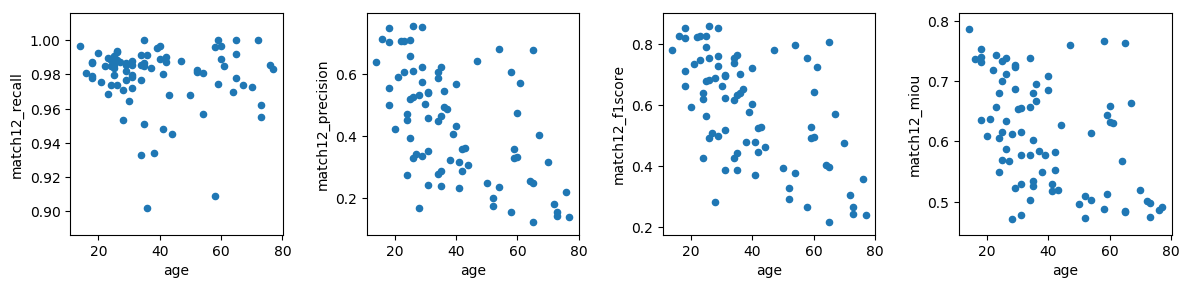

In [144]:
fig, ax = plt.subplots(1, 4, figsize=(12, 3), dpi=100)
big_table.plot.scatter('age', 'match12_recall', ax=ax[0])
big_table.plot.scatter('age', 'match12_precision', ax=ax[1])
big_table.plot.scatter('age', 'match12_f1score', ax=ax[2])
big_table.plot.scatter('age', 'match12_miou', ax=ax[3])
plt.tight_layout()
plt.show()

In [152]:
columns = ['subject_id', 's1_number', 's1_density', 's2_number', 's2_density', 'match12_precision']
where = big_table['match12_precision'] < 0.3
big_table[where][columns].sort_values(by='s1_density')

,subject_id,s1_number,s1_density,s2_number,s2_density,match12_precision
101,8-002,60,0.206540,431,1.483649,0.136891
13,1-014,53,0.299435,221,1.248588,0.239819
98,7-021,53,0.307246,364,2.110145,0.140110
10,1-011,43,0.323308,246,1.849624,0.166667
76,6-009,44,0.329588,258,1.932584,0.155039
96,7-019,45,0.348837,358,2.775194,0.122905
70,6-003,58,0.393220,288,1.952542,0.197917
69,6-002,53,0.394052,301,2.237918,0.172757
7,1-008,80,0.398010,275,1.368159,0.287273
77,6-010,93,0.458128,365,1.798030,0.246575


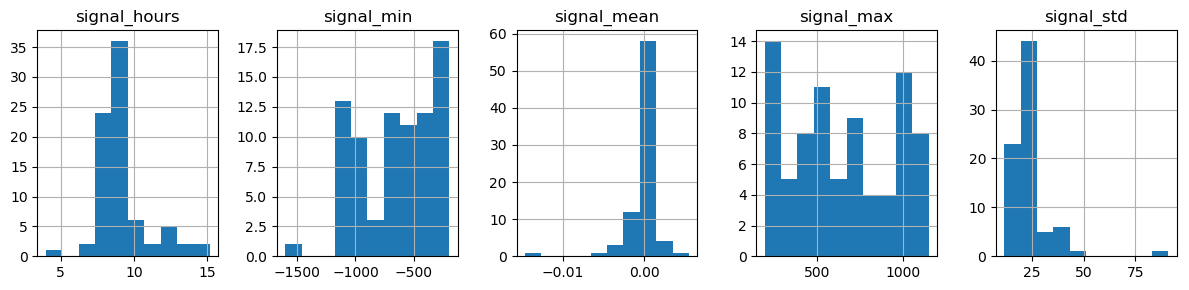

In [155]:
fig, ax = plt.subplots(1, 5, figsize=(12, 3), dpi=100)
big_table.hist('signal_hours', ax=ax[0])
big_table.hist('signal_min', ax=ax[1])
big_table.hist('signal_mean', ax=ax[2])
big_table.hist('signal_max', ax=ax[3])
big_table.hist('signal_std', ax=ax[4])
plt.tight_layout()
plt.show()

In [157]:
columns = ['subject_id', 'signal_std', 'signal_min', 'signal_max']
where = big_table.signal_std > 25
big_table[where][columns].sort_values(by='signal_std')

,subject_id,signal_std,signal_min,signal_max
21,3-004,25.110348,-979.761841,1078.760864
12,1-013,25.932695,-196.884048,226.664703
42,5-012,26.091681,-1032.578735,974.252014
63,5-036,26.422842,-991.712158,1010.157715
37,5-007,26.550585,-338.367828,693.700500
10,1-011,27.063383,-662.229553,841.013306
89,7-012,27.233503,-1104.343872,1057.863159
56,5-026,27.753036,-268.838928,262.669250
47,5-017,29.315435,-1036.629028,1056.354248
6,1-007,29.383022,-317.063019,341.994568


In [172]:
columns = ['subject_id', 'signal_hours', 'hypno_sleep_hours', 'hypno_n2_hours', 's1_density', 's2_density', 's1_number', 's2_number']
where = big_table.signal_hours < 7
big_table[where][columns]

,subject_id,signal_hours,hypno_sleep_hours,hypno_n2_hours,s1_density,s2_density,s1_number,s2_number
16,2-001,3.983611,2.633333,1.200000,1.805556,3.916667,130,282
31,4-005,6.800000,3.716667,1.241667,0.510067,1.812081,38,135


In [180]:
columns = ['subject_id', 'signal_hours', 'hypno_sleep_hours', 'hypno_n2_hours', 's1_density', 's2_density', 's1_number', 's2_number', 'hypno_flag_sanity']
where = big_table.hypno_flag_sanity == False
big_table[where][columns]

,subject_id,signal_hours,hypno_sleep_hours,hypno_n2_hours,s1_density,s2_density,s1_number,s2_number,hypno_flag_sanity
11,1-012,8.250000,7.933333,3.525,4.860520,6.373522,1028,1348,False
15,1-016,8.555556,8.191667,3.775,0.896247,2.772627,203,628,False
16,2-001,3.983611,2.633333,1.200,1.805556,3.916667,130,282,False


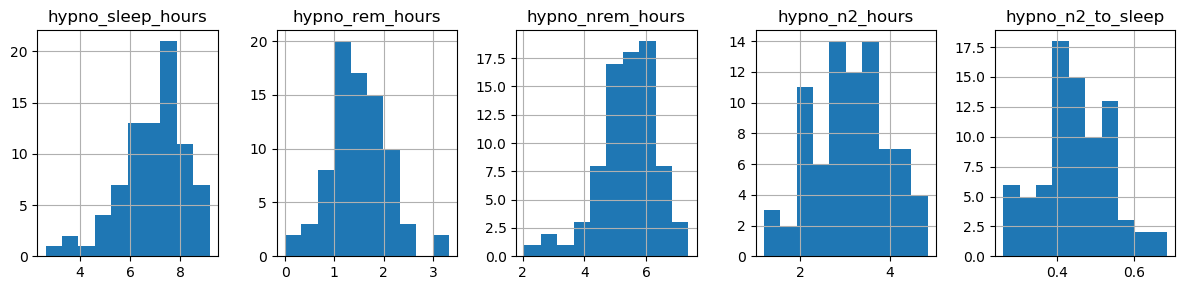

In [197]:
fig, ax = plt.subplots(1, 5, figsize=(12, 3), dpi=100)
big_table.hist('hypno_sleep_hours', ax=ax[0])
big_table.hist('hypno_rem_hours', ax=ax[1])
big_table.hist('hypno_nrem_hours', ax=ax[2])
big_table.hist('hypno_n2_hours', ax=ax[3])
big_table.hist('hypno_n2_to_sleep', ax=ax[4])
plt.tight_layout()
plt.show()

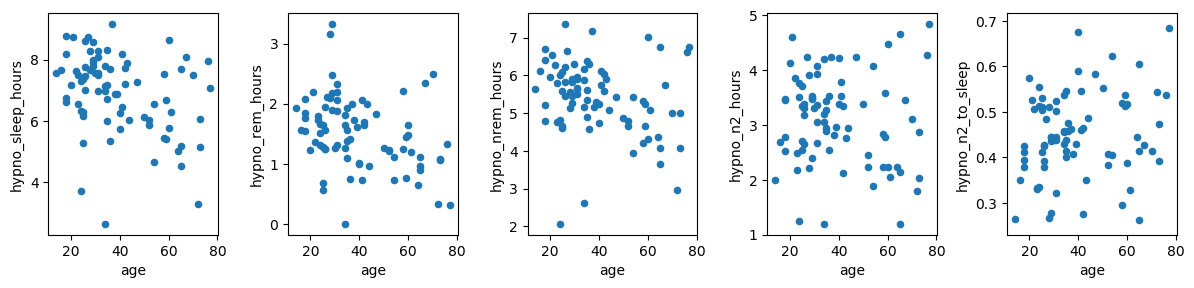

In [204]:
fig, ax = plt.subplots(1, 5, figsize=(12, 3), dpi=100)
big_table.plot.scatter('age', 'hypno_sleep_hours', ax=ax[0])
big_table.plot.scatter('age', 'hypno_rem_hours', ax=ax[1])
big_table.plot.scatter('age', 'hypno_nrem_hours', ax=ax[2])
big_table.plot.scatter('age', 'hypno_n2_hours', ax=ax[3])
big_table.plot.scatter('age', 'hypno_n2_to_sleep', ax=ax[4])
plt.tight_layout()
plt.show()

In [202]:
columns = ['subject_id', 'signal_hours', 'hypno_sleep_hours', 'hypno_n2_hours', 'hypno_rem_hours', 's1_density', 's2_density']
where = big_table.hypno_sleep_hours < 5
big_table[where][columns]

,subject_id,signal_hours,hypno_sleep_hours,hypno_n2_hours,hypno_rem_hours,s1_density,s2_density
16,2-001,3.983611,2.633333,1.200000,0.000000,1.805556,3.916667
23,3-006,13.416667,4.675000,1.891667,0.733333,0.458150,1.911894
26,3-009,9.308333,3.300000,1.791667,0.333333,0.669767,3.730233
31,4-005,6.800000,3.716667,1.241667,1.658333,0.510067,1.812081
100,8-001,7.850000,4.541667,1.191667,0.891667,0.573427,2.321678


In [203]:
pprint(list(big_table.columns.values))

['subject_id',
 'channel',
 'pathology',
 'age',
 'sex',
 'signal_hours',
 'signal_min',
 'signal_mean',
 'signal_std',
 'signal_max',
 'power_delta_slow',
 'power_delta_fast',
 'power_theta',
 'power_alpha',
 'power_sigma',
 'power_beta',
 'power_ratio',
 'hypno_rem_hours',
 'hypno_n1_hours',
 'hypno_n2_hours',
 'hypno_n3_hours',
 'hypno_n4_hours',
 'hypno_nrem_hours',
 'hypno_sleep_hours',
 'hypno_n2_to_sleep',
 'hypno_flag_sanity',
 's1_number',
 's1_density',
 's1_duration',
 's2_number',
 's2_density',
 's2_duration',
 'match12_recall',
 'match12_precision',
 'match12_f1score',
 'match12_miou',
 's1_freq',
 's1_amp_pp',
 's1_amp_rms',
 's1_power_ratio',
 's2_freq',
 's2_amp_pp',
 's2_amp_rms',
 's2_power_ratio']


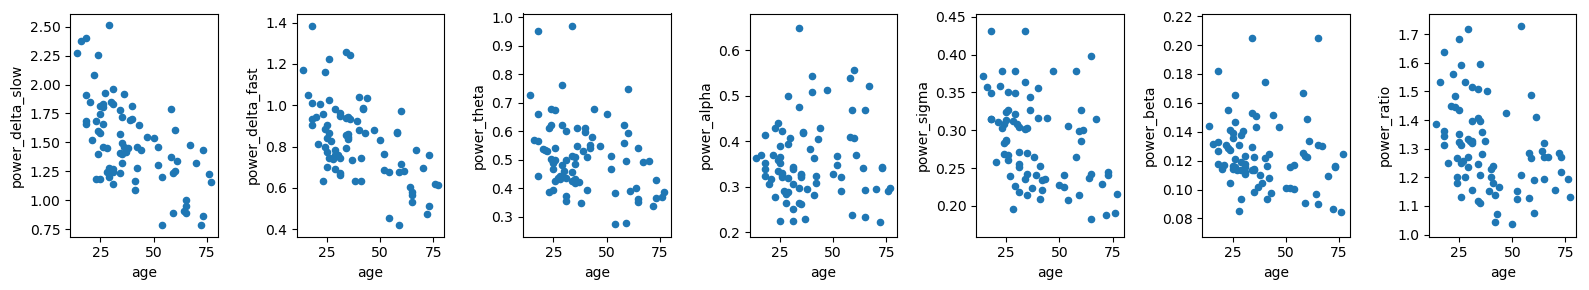

In [206]:
fig, ax = plt.subplots(1, 7, figsize=(16, 3), dpi=100)
big_table.plot.scatter('age', 'power_delta_slow', ax=ax[0])
big_table.plot.scatter('age', 'power_delta_fast', ax=ax[1])
big_table.plot.scatter('age', 'power_theta', ax=ax[2])
big_table.plot.scatter('age', 'power_alpha', ax=ax[3])
big_table.plot.scatter('age', 'power_sigma', ax=ax[4])
big_table.plot.scatter('age', 'power_beta', ax=ax[5])
big_table.plot.scatter('age', 'power_ratio', ax=ax[6])
plt.tight_layout()
plt.show()

In [217]:
columns = ['subject_id', 'power_sigma', 'power_ratio', 's1_density', 's2_density', 'power_theta']
where = big_table.power_theta > 0.65
big_table[where][columns].sort_values(by='power_theta')

,subject_id,power_sigma,power_ratio,s1_density,s2_density,power_theta
35,5-004,0.314454,1.345771,3.498795,4.857831,0.659645
77,6-010,0.228107,1.038041,0.458128,1.798030,0.659971
37,5-007,0.261138,1.131981,0.760494,2.306173,0.675178
62,5-035,0.316556,1.165938,0.615819,1.898305,0.676554
12,1-013,0.308839,1.201307,1.254157,2.750594,0.678422
38,5-008,0.371185,1.387748,2.641667,4.108333,0.726258
67,5-040,0.326436,1.075666,0.684015,2.044610,0.746656
34,5-003,0.378389,1.335549,3.269690,5.126492,0.762446
29,4-003,0.430868,1.313333,2.066225,3.668874,0.952986
16,2-001,0.431229,1.118852,1.805556,3.916667,0.967430


In [220]:
pprint(list(exclusion_list))

['3-002',
 '3-003',
 '4-002',
 '5-001',
 '6-004',
 '6-006',
 '6-007',
 '7-001',
 '7-002',
 '7-003',
 '7-004',
 '7-005',
 '7-007',
 '7-008',
 '7-009',
 '7-010',
 '7-011',
 '7-013',
 '7-014',
 '7-015',
 '7-017',
 '7-020',
 '8-003',
 '8-004']


In [11]:
sleep_labels = ['S1', 'S2', 'S3', 'S4', 'R']
hypnogram_page_size = int(loader.original_page_duration * loader.fs)

data = loader.read_subject_data('1-001')
x = data['signal']
hypno = data['hypnogram_original']
pages = np.concatenate([np.where(hypno == lbl)[0] for lbl in sleep_labels])
x = utils.extract_pages(x, pages, hypnogram_page_size).flatten()
print(x.shape)

(6606000,)


In [7]:
tmp = [np.where(hypno == lbl)[0] for lbl in sleep_labels]

In [9]:
[print(tmp[i].shape) for i in range(5)]

(33,)
(508,)
(135,)
(186,)
(239,)


[None, None, None, None, None]